In [21]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io, transform
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

In [2]:
PATH = '../data/faces/'

In [3]:
ls {PATH}*.c*

../data/faces/face_landmarks.csv


In [4]:
!head -n 1 {PATH}face_landmarks.csv

In [5]:
!wc {PATH}*.csv

      70      70   39465 ../data/faces/face_landmarks.csv


In [6]:
file_name = 'face_landmarks.csv'
landmark_df = pd.read_csv(PATH + file_name)
landmark_df.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [7]:
landmark_df.shape

(69, 137)

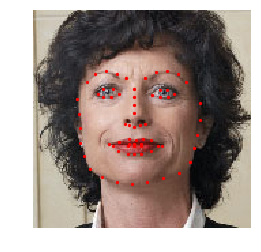

In [8]:
img = landmark_df.iloc[65, 0]
landmarks = landmark_df.iloc[65, 1:].values.reshape(-1, 2)

img_arry = plt.imread(os.path.join(PATH, img))
plt.imshow(img_arry)
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=5, color='r')
plt.axis('off');

In [10]:
class FaceLandmarksDataset(Dataset):
    '''
    Implement custom Dataset class to get images and its corresponding
    landmarks.
    '''

    def __init__(self, file_name, root_dir, transform=None):
        self.landmarks_df = pd.read_csv(file_name)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_df)
    
    def __getitem__(self, index):
        img_name = self.landmarks_df.iloc[index, 0]
        img = io.imread(os.path.join(self.root_dir, img_name))
        landmarks = self.landmarks_df.iloc[index, 1:].values
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': img, 'landmarks': landmarks}
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample

(324, 215, 3) (68, 2)
(500, 333, 3) (68, 2)
(250, 258, 3) (68, 2)
(434, 290, 3) (68, 2)


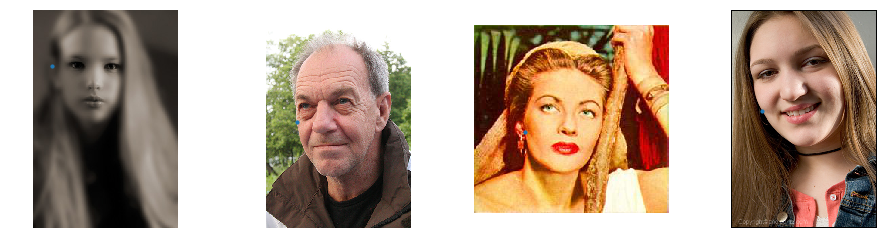

In [14]:
faces_dataset = FaceLandmarkDataset(file=PATH + file_name, root_dir=PATH)
fig = plt.figure(figsize=(16, 4))
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    sample = faces_dataset[i]
    img, landmarks = sample['image'], sample['landmarks']
    print(img.shape, landmarks.shape)
    plt.imshow(img)
    plt.scatter(landmarks[i, 0], landmarks[i, 1], s=10)
    plt.axis('off')

In [15]:
class Rescale:
    '''Resize an image to a give output size.'''

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple, list))
        if isinstance(output_size, (tuple, list)):
            assert len(output_size) == 2
            self.new_h, self.new_w = output_size
        else:
            self.new_h, self.new_w = (output_size, output_size)
    
    def __call__(self, sample):
        img, landmarks = sample['image'], sample['landmarks']
        h, w = img.shape[:2]
    
        img = transform.resize(img, (self.new_h, self.new_w))
        landmarks = landmarks * [self.new_w / w, self.new_h / h]
        sample = {'image': img, 'landmarks': landmarks}

        return sample

(224, 224, 3) (68, 2)
(224, 224, 3) (68, 2)
(224, 224, 3) (68, 2)
(224, 224, 3) (68, 2)


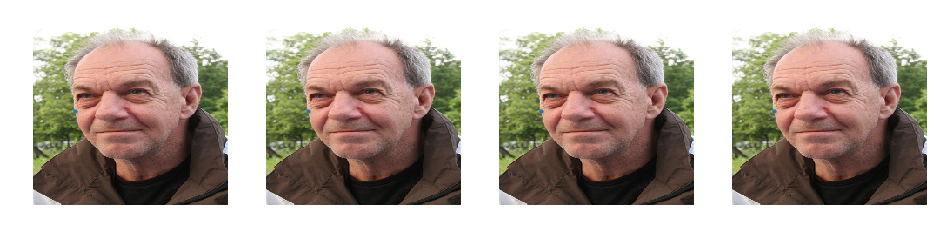

In [18]:
faces_dataset = FaceLandmarkDataset(PATH + 'face_landmarks.csv', PATH, transform=Rescale(224))
fig = plt.figure(figsize=(16, 4))
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    sample = faces_dataset[1]
    img, landmarks = sample['image'], sample['landmarks']
    print(img.shape, landmarks.shape)
    plt.imshow(img)
    plt.scatter(landmarks[1, 0], landmarks[1, 1], s=10)
    plt.axis('off')

In [37]:
class RandomCrop:
    '''Randomly crop an image to a given output size.'''

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple, list))
        if isinstance(output_size, (tuple, list)):
            assert len(output_size) == 2
            self.new_h, self.new_w = output_size
        else:
            self.new_h, self.new_w = (output_size, output_size)
    
    def __call__(self, sample):
        img, landmarks = sample['image'], sample['landmarks']
        h, w = img.shape[:2]

        top_left = np.random.randint(0, h - self.new_h)
        bottom_left = np.random.randint(0, w - self.new_w)
        img = img[top_left:(top_left + self.new_h), bottom_left:(bottom_left + self.new_w)]
        landmarks = landmarks - [bottom_left, top_left]
        sample = {'image': img, 'landmarks': landmarks}

        return sample

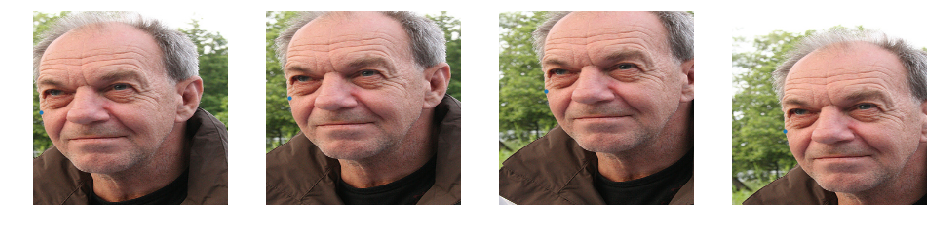

In [38]:
faces_transforms = transforms.Compose([
    Rescale(256),
    RandomCrop(200)
])
faces_dataset = FaceLandmarkDataset(PATH + 'face_landmarks.csv', PATH, transform=faces_transforms)
fig = plt.figure(figsize=(16, 4))
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    sample = faces_dataset[1]
    img, landmarks = sample['image'], sample['landmarks']
    plt.imshow(img)
    plt.scatter(landmarks[1, 0], landmarks[1, 1], s=10)
    plt.axis('off')

In [43]:
class ToTensor:
    '''Convert a given image from numpy array to tensor.'''

    def __call__(self, sample):
        img, landmarks = sample['image'], sample['landmarks']
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img)
        landmarks = torch.from_numpy(landmarks)
        sample = {'image': img, 'landmarks': landmarks}

        return sample

In [44]:
# Put everything together
faces_transforms = transforms.Compose([
    Rescale(256),
    RandomCrop(224),
    ToTensor()
])

transformed_dataset = FaceLandmarksDataset(PATH + file_name, PATH, faces_transforms)

faces_dataloader = DataLoader(transformed_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=4)

In [58]:
sample = iter(faces_dataloader).__next__()
images, landmarks = sample['image'], sample['landmarks']

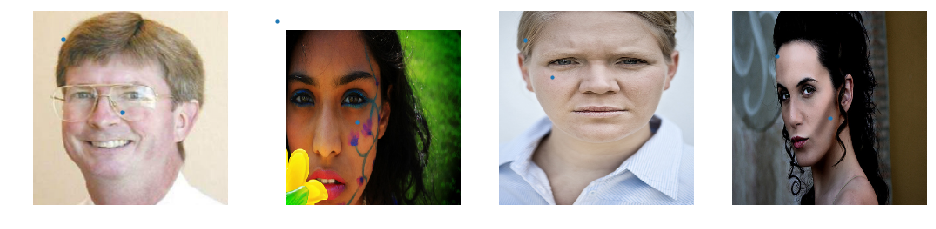

In [59]:
fig = plt.figure(figsize=(16, 4))
for img, landmark, i in zip(images, landmarks, range(4)):
    fig.add_subplot(1, 4, i + 1)
    img, landmark = img.numpy(), landmark.numpy()
    img = img.transpose(1, 2, 0)
    plt.imshow(img)
    plt.scatter(landmarks[i, 0], landmarks[i, 1], s=10)
    plt.axis('off')